In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import sys
import gensim
import gensim.downloader as model_api
from collections import Counter
import requests
pd.options.display.max_colwidth = 1000

In [2]:
# Importing modules from functions folder
from functions.get_data import scrape_data
from functions.clean_data import sentence_cleaning
from functions.vectorizer_kmean_models import cvector_kmean_model, tfid_kmean_model, p_trained_vectorizer_kmean_model
from functions.wcss import wcss_plot
from functions.visualization import visualizing_pca

# Olympics Tokyo Tweets

This data set contains 5000 tweets from 2021-07-27 to 2021-08-06 in english about Tokyo Olympics.

Note: First time it is required to run the cell below to scrape the data. Then the scraped data would be saved as a csv file.

In [3]:
# # Scraping data by get_data.py
# from functions.get_data import scrape_data
# number_tweets = 5000
# query = "Olympics Tokyo lang:en until:2021-08-06 since:2021-07-27 -filter:links -filter:replies"
# data = scrape_data(query,number_tweets)

In [4]:
# # Save the data as csv 
# data.to_csv('olympic_tweets.csv',index=False)

Dataset has some duplicate tweets. After first round of analysis these tweets were detected and then were removed from the dataset. A new clean dataset is provided as 'data_clean_indian_headlines.csv'. The code for detecting the duplicates in first round is [here](#here).

In [5]:
# 1 strat with 5000 tweets
#data = pd.read_csv('olympic_tweets.csv')

# 2 reduced indian_hockey top_headline tweets
data = pd.read_csv('data_clean_indian_headlines.csv')

# Keeping original tweets as data_origin for interpreting 
data_origin = data.copy()

#### Dataset cleaning steps:
- converting all words to lowercase
- removing all stop words such as: me, I, and, a ...
- removing most frequent words such as Tokyo, olympics, olimpic
- removing punctuation marks
- removing emojis

In [6]:
# Cleaning the dataset

most_frequesnt_words = ['tokyo','olympics','olympic']
data = sentence_cleaning(df = data.Tweet,most_used_words = most_frequesnt_words)

#### Here is the result:

In [7]:
# Original dataset
data_origin.head(3)

,Tweet
0,The best photos from the Tokyo Olympics
1,#IAmCaptain Cheering team kenya and watching Tokyo Olympics \n@WorldAthletics\n @OlympicsKe\n @CapMorganGoldKE ❤️❤️
2,"We have a big problem of brain drain in every aspect, moreover, there are no remittances from this current brain drain as most are 2nd generation immigrants. If you doubt me, check out this Tokyo Olympics."


In [8]:
# Cleaned dataset
data.head(3)

,Tweet
0,best photos
1,iamcaptain cheering team kenya watching worldathletics olympicske capmorgangoldke
2,big problem brain drain every aspect moreover remittances current brain drain 2nd generation immigrants doubt check


### Vectorizing data
For vectorizing data, three different methods are used. 
- TfidfVectorizer
- CountVectorizer
- pretrained model ("glove-twitter-25")

For pre trained model, it is required to download the model. For the first time it may takes time to download it, but for next time it won't take long.

In [9]:
# Downloading pretrained vectorizer
import sys
import gensim
import gensim.downloader as model_api

pretrained_vectorizer = model_api.load("glove-twitter-25")  # load glove vectors

Three function are defined to first get the data, second vectorize it and third fit it with kmeans cluster model. 
- cvector_kmean_model
- tfid_kmean_model
- p_trained_vectorizer_kmean_model

In [10]:
# Getting vectorized data
data_cvector = cvector_kmean_model(data=data.Tweet, number_clusters=2)[1]
data_tfid    = tfid_kmean_model(data=data.Tweet, number_clusters=2)[1]
data_ptrained_vec = p_trained_vectorizer_kmean_model(
    pretrained_embeded =pretrained_vectorizer,data=data.Tweet, number_clusters=2)[1]

### WCSS

wcss method is used to get the number of clusters for each model

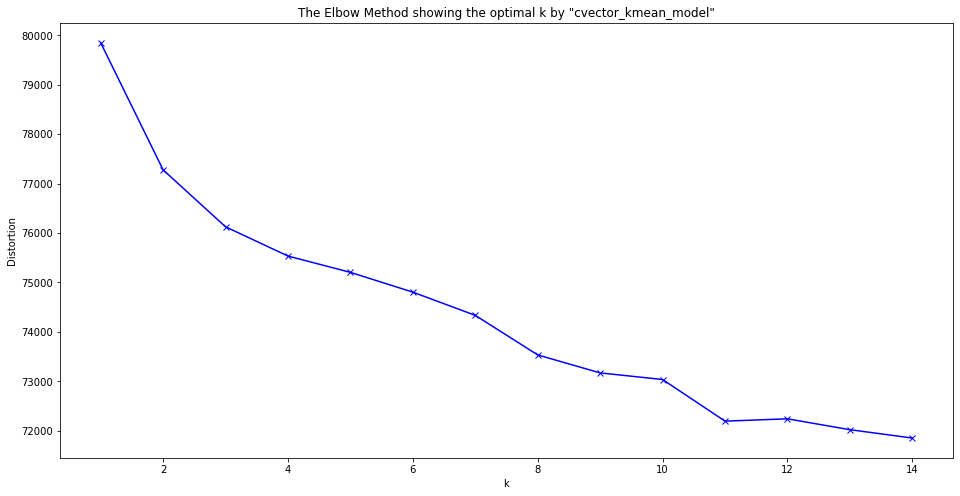

In [11]:
# WCSS for cvector_kmean_model
wcss_plot(data=data_cvector, n_clusters=15, vectorizer_name='cvector_kmean_model')

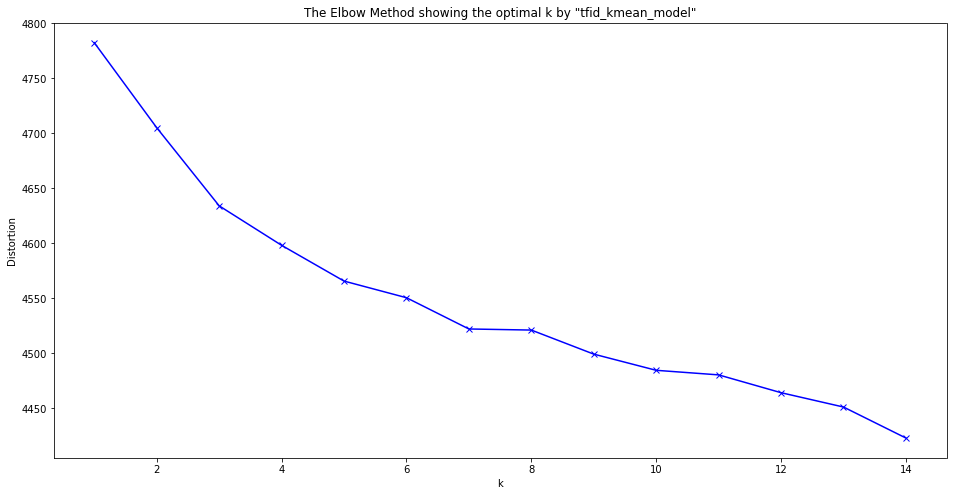

In [12]:
# WCSS for tfid_kmean_model
wcss_plot(data=data_tfid, n_clusters=15, vectorizer_name='tfid_kmean_model')

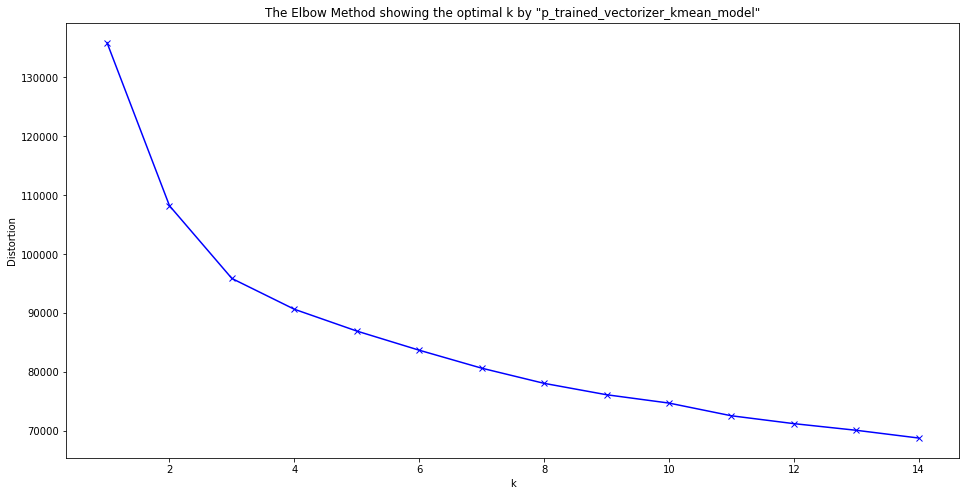

In [13]:
# WCSS for p_trained_vectorizer_kmean_model
wcss_plot(data=data_ptrained_vec, n_clusters=15, vectorizer_name='p_trained_vectorizer_kmean_model')

Based on the wcss plots, the proper number of clusters are choosen for clustering. The cluster labels of each model are added to the dataset.

In [14]:
# Assigning label of clusters to dataset for cvector_kmean_model
km_cvector, data_cvector, pred_cvector = cvector_kmean_model(data=data.Tweet, number_clusters=3)
data['labelcvec'] = pred_cvector

# Assigning label of clusters to dataset for tfid_kmean_model
km_tfid, data_tfid, pred_tfid = tfid_kmean_model(data=data.Tweet, number_clusters=3)
data['labeltfid'] = pred_tfid

# Assigning label of clusters to dataset for p_trained_vectorizer_kmean_model pretrained_embeded, data
km_model, data_ptrained_vec, pred_ptrained_vec = p_trained_vectorizer_kmean_model(
    pretrained_embeded = pretrained_vectorizer, data=data.Tweet, number_clusters=3)
data['labelptrainedvec'] = pred_ptrained_vec

Then the models are compared based on the clusters they have identified. The goal is to find a model which can detect meaningful patterns between different tweets.

#### Comparing tweets of different clusters on Cvectorizer model:

In [15]:
# data['labelcvec'].value_counts()

In [16]:
# data_origin[data['labelcvec']==0]

In [17]:
# Counter(" ".join(data.loc[data['labelcvec']==0,'Tweet']).split()).most_common(10)

In [18]:
# data_origin[data['labelcvec']==1]

In [19]:
# Counter(" ".join(data.loc[data['labelcvec']==1,'Tweet']).split()).most_common(10)

In [20]:
# data_origin[data['labelcvec']==2]

In [21]:
# Counter(" ".join(data.loc[data['labelcvec']==2,'Tweet']).split()).most_common(10)

#### Comparing tweets of different clusters on tfidfVectorizer model:

In [22]:
# data['labeltfid'].value_counts()

In [23]:
# data_origin[data['labeltfid']==0]

In [24]:
# Counter(" ".join(data.loc[data['labeltfid']==0,'Tweet']).split()).most_common(10)

In [25]:
# data_origin[data['labeltfid']==1]

In [26]:
# Counter(" ".join(data.loc[data['labeltfid']==1,'Tweet']).split()).most_common(10)

In [27]:
# data_origin[data['labeltfid']==2]

In [28]:
# Counter(" ".join(data.loc[data['labeltfid']==2,'Tweet']).split()).most_common(10)

Comparing tweets of different clusters on pre trained Vectorizer model:

In [29]:
# data['labelptrainedvec'].value_counts()

In [30]:
# data_origin[data['labelptrainedvec']==0]

In [31]:
# Counter(" ".join(data.loc[data['labelptrainedvec']==0,'Tweet']).split()).most_common(10)

In [32]:
# data_origin[data['labelptrainedvec']==1]

In [33]:
# Counter(" ".join(data.loc[data['labelptrainedvec']==1,'Tweet']).split()).most_common(10)

In [34]:
# data_origin[data['labelptrainedvec']==2]

In [35]:
# Counter(" ".join(data.loc[data['labelptrainedvec']==2,'Tweet']).split()).most_common(10)

<a id='here'></a>
#### Cleaning some duplicate tweets and creating new csv file in first round of Analysis

In [36]:
# data_clean_indian_topheadlines = data_origin[(data['labelcvec']!=4) & (data['labelcvec']!=3)]
# data_clean_indian_topheadlines.Tweet.to_csv('data_clean_indian_headlines.csv',index=False)

# Visualizing using dimensionality reduction(PCA)



data.shape =  (4854, 11991)
projected.shape =  (4854, 2)


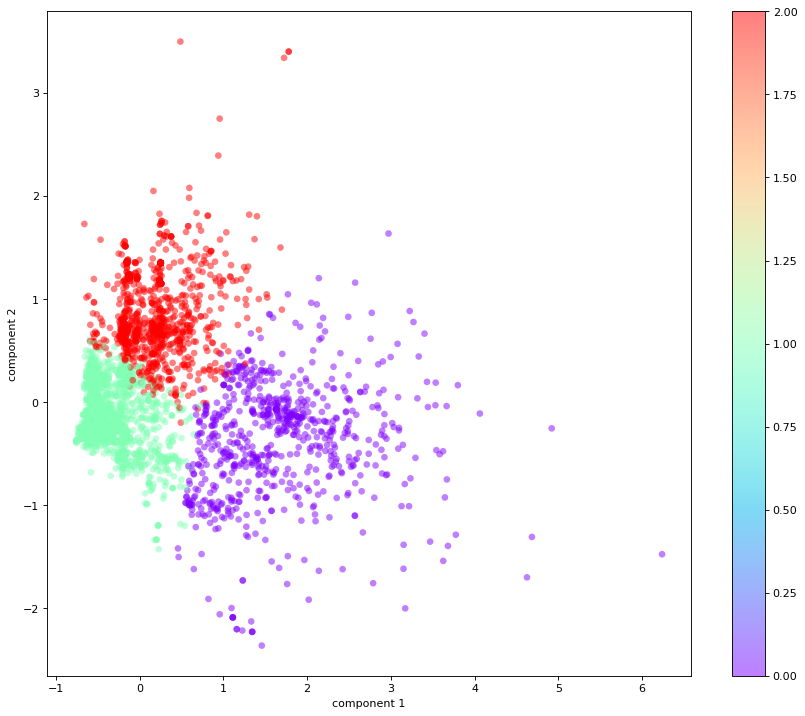

In [37]:
# Visualizing cvector_kmean_model
visualizing_pca(vectorized_data = data_cvector.toarray(), data_label = data.labelcvec)

data.shape =  (4854, 11991)
projected.shape =  (4854, 2)


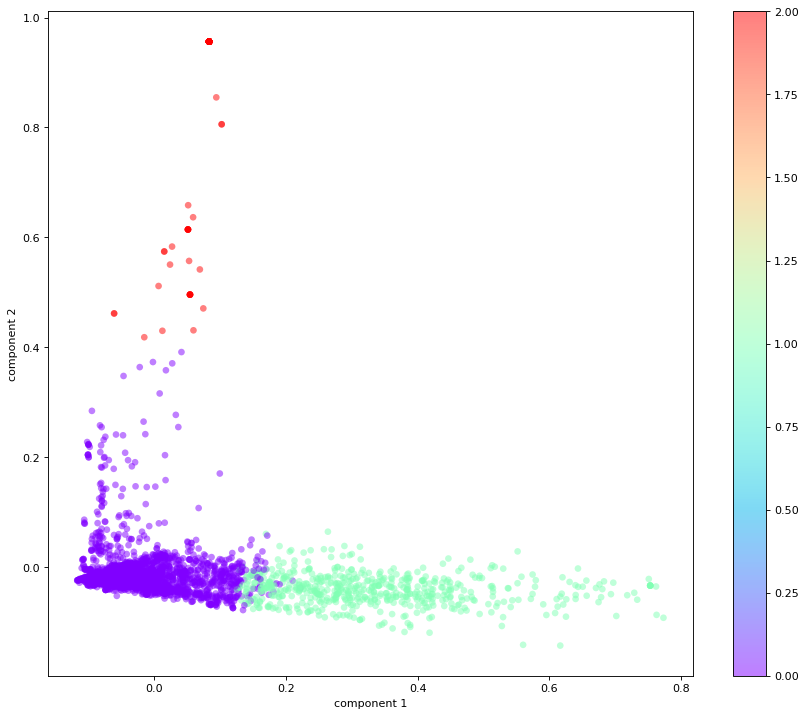

In [38]:
# Visualizing tfid_kmean_model
visualizing_pca(vectorized_data = data_tfid.toarray(), data_label = data.labeltfid)

data.shape =  (4854, 25)
projected.shape =  (4854, 2)


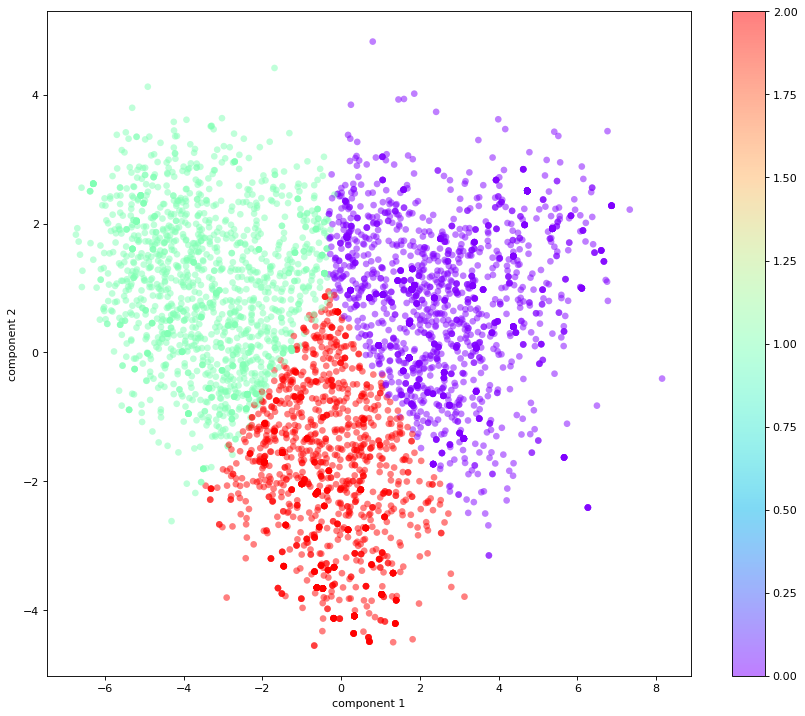

In [39]:
# Visualizing p_trained_vectorizer_kmean_model
visualizing_pca(vectorized_data = data_ptrained_vec, data_label = data.labelptrainedvec)

#### The conclusion is provided in README file.